In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore')

In [7]:
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (20, 6) 
sns.set(context="paper", font="monospace") 

In [8]:
df = pd.read_csv('throughput_metrics.csv', parse_dates=['Time'], index_col='Time')
# df.reset_index(inplace=True)
df.head() 

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2018-01-01 08:00:00,1.411093e+10,1.109243e+09,8.289831e+07,56650005.21,1.117868e+07,827420.9772
2018-01-01 09:00:00,1.345362e+10,1.242256e+09,4.375739e+04,49307351.26,7.070847e+06,913017.6007
2018-01-01 10:00:00,1.216888e+10,2.006322e+09,4.315725e+04,56843652.59,5.132826e+07,874471.3644
2018-01-01 11:00:00,1.123120e+10,1.073181e+09,8.277154e+07,46645240.59,5.217827e+06,837246.7783
2018-01-01 12:00:00,1.078085e+10,8.645069e+08,3.343548e+04,30966947.37,7.495363e+06,827143.7497


In [9]:
df.shape 

(8760, 6)

In [10]:
df.index

DatetimeIndex(['2018-01-01 08:00:00', '2018-01-01 09:00:00',
               '2018-01-01 10:00:00', '2018-01-01 11:00:00',
               '2018-01-01 12:00:00', '2018-01-01 13:00:00',
               '2018-01-01 14:00:00', '2018-01-01 15:00:00',
               '2018-01-01 16:00:00', '2018-01-01 17:00:00',
               ...
               '2018-12-31 22:00:00', '2018-12-31 23:00:00',
               '2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00'],
              dtype='datetime64[ns]', name='Time', length=8760, freq=None)

In [11]:
sum(df.isna().sum())

0

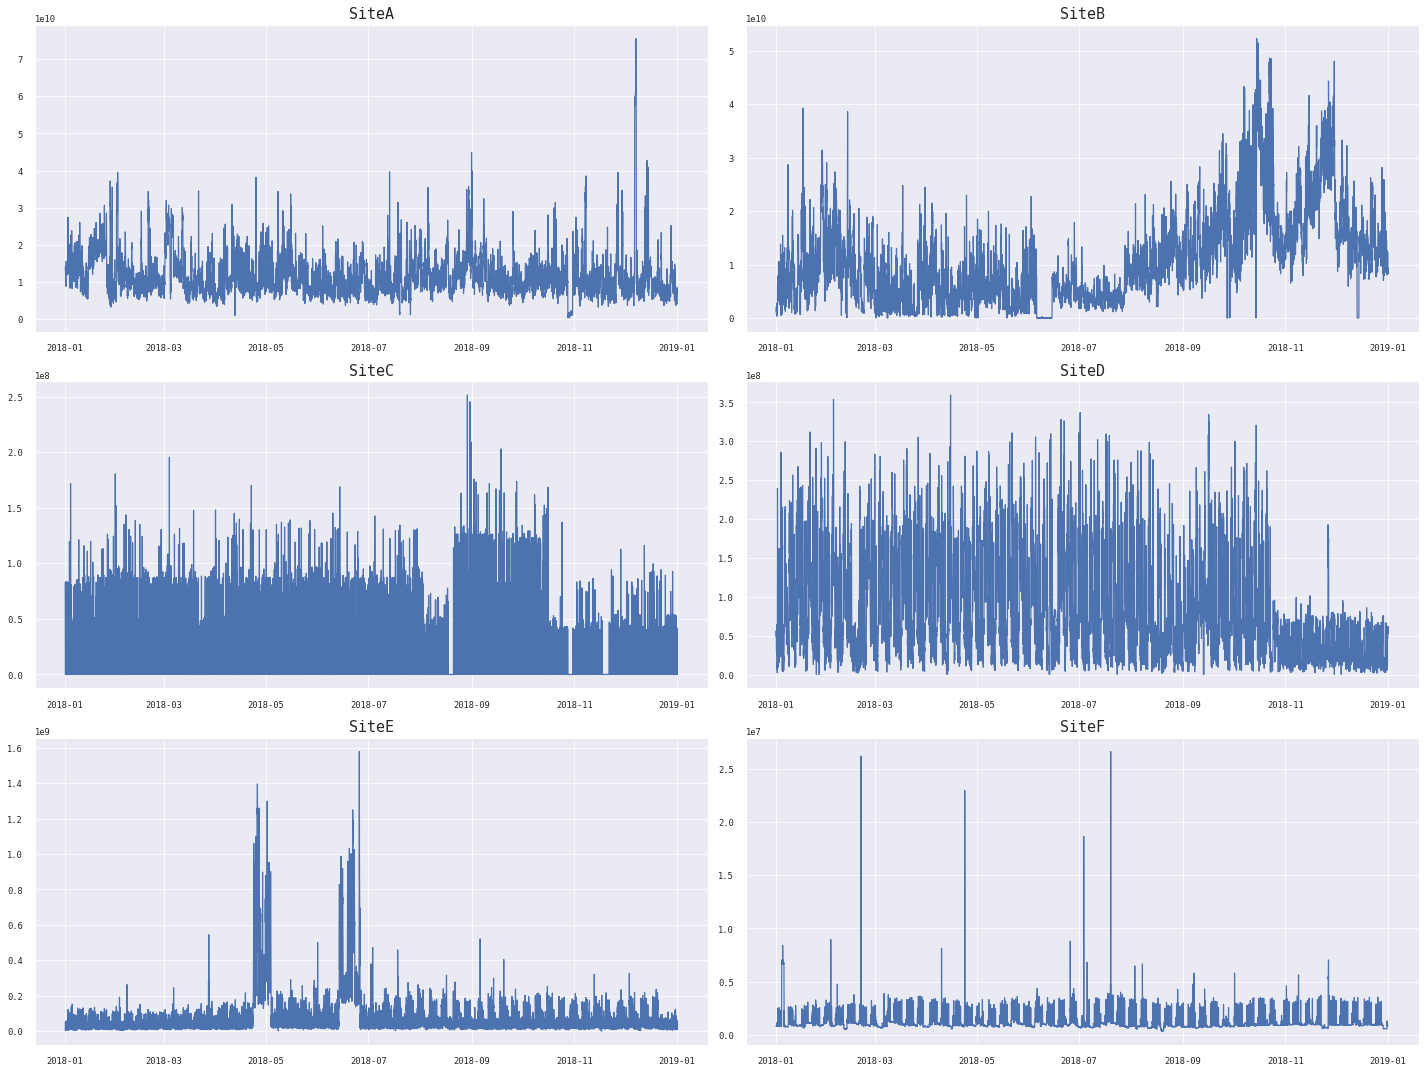

In [12]:
c = 1
fig = plt.figure(figsize=(20,15))
for col in df.columns:
    plt.subplot(3, 2, c)
    plt.title(f'{col}', size=15)
    plt.tight_layout()
    plt.plot(df[col])
    c += 1
plt.show() 

In [13]:
# missing value treatment
df['SiteB'][df['SiteB'] == 0] = df['SiteB'].mean()

In [14]:
df[df['SiteB'] == 0]

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,


In [15]:
# checking stationarity 
cj_stat = coint_johansen(df,-1,1).eig 
print(cj_stat) 

[0.38782114 0.16822476 0.07955193 0.04133012 0.02690916 0.00513086]


In [16]:
# [print('Non Stationary') for i in cj_stat if i < 1] 

In [17]:
# creating the train and validation set
# train = df[:int(0.8*(len(df)))]
# valid = df[int(0.8*(len(df))):]

nobs = 1
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)

(8759, 6)
(1, 6)


In [18]:
# fit the model
model = VAR(df_train)
model_fit = model.fit()

In [19]:
# Input data for forecasting
forecast_input = df_train.values[-nobs:]
forecast_input 

array([[6.88469466e+09, 9.62731719e+09, 7.31901028e+04, 6.26614479e+07,
        6.15230605e+07, 8.79444753e+05]])

In [20]:
# Forecast
fc = model_fit.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns)
df_forecast  

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2019-01-01 07:00:00,7.546767e+09,9.795331e+09,2.600965e+07,6.448225e+07,6.392096e+07,1.032568e+06


In [21]:
result = dict()
# check rmse
for i in df.columns: 
    result[f'{i} RMSE'] = np.sqrt(mean_squared_error(df_forecast[i], df_test[i]))
    # print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(df_forecast[i], df_test[i])))
print(result) 

{'SiteA RMSE': 1128807727.8593187, 'SiteB RMSE': 2484787615.5402966, 'SiteC RMSE': 25936459.75449342, 'SiteD RMSE': 8183503.121821545, 'SiteE RMSE': 52947582.644412406, 'SiteF RMSE': 124809.94446083612}


In [22]:
# make final predictions
model = VAR(df)
model_fit = model.fit() 
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)  

[[9.06783022e+09 1.23145775e+10 2.52800193e+07 5.85084869e+07
  1.78657481e+07 1.03120020e+06]]
